## Find me Love

#### This is a dating recommender system which would suggest the relevant profiles to users. Libimset dataset has been used to build the system. We focus on recommendation systems of different types:
#### 1. Popular Profiles Recommendation
#### 2. Profile Recommendation using Weighted Average
#### 3. Profile Recommendation using Pearson Correlation
#### 4. Recommendations using Collaborative Filtering(Item-Item) based on KNN
#### 5. Recommendations using Collaborative Filtering(User-User)

In [1]:
import pandas as pd
import numpy as np
gender = pd.read_csv('data/gender.dat',names = ['userid','gender'],header=None)
ratings = pd.read_csv('data/ratings.dat',names = ['userid','profileid','rating'],header=None)

In [2]:
gender.head()

,userid,gender
0,1,F
1,2,F
2,3,U
3,4,F
4,5,F


In [3]:
ratings.head()

,userid,profileid,rating
0,1,133,8
1,1,720,6
2,1,971,10
3,1,1095,7
4,1,1616,10


In [4]:
dataset = pd.merge(gender,ratings,on='userid')
dataset.head()

,userid,gender,profileid,rating
0,1,F,133,8
1,1,F,720,6
2,1,F,971,10
3,1,F,1095,7
4,1,F,1616,10


In [5]:
dataset.isnull().sum()

userid       0
gender       0
profileid    0
rating       0
dtype: int64

#### We see that there are no missing values in the dataset.

## Exploratory Data Analysis

In [6]:
dataset[['rating','gender']].describe(include='all')

,rating,gender
count,1.735935e+07,17359346
unique,NaN,3
top,NaN,F
freq,NaN,10804043
mean,5.938437e+00,NaN
std,3.112005e+00,NaN
min,1.000000e+00,NaN
25%,3.000000e+00,NaN
50%,6.000000e+00,NaN
75%,9.000000e+00,NaN


In [7]:
dataset['gender'].value_counts().plot(kind='bar')

#### We have 3 types of genders: M for Male, F for Female and U for Unknown. The highest number of users on the platform are Females

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fa6b2f9d0b8>]],
      dtype=object)

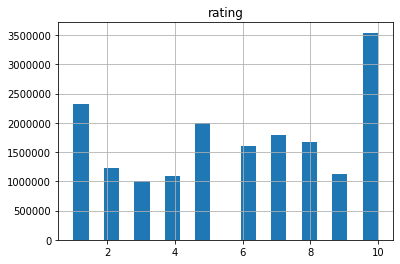

In [8]:
dataset[['rating']].hist(bins=20)

#### The highest number of ratings are 10. Seems the platform has many favourite profiles.

## 1. Popular Profiles Recommendation

#### Here, we find the top 10 profiles on our platform using the below approach. This is essential in a cold start recommendation system when a new user has joined in and we do not have any details about his preference.

Note: There can be various criterias to measure top 10 profiles, we cover below two strategies: Profiles with highest number of ratings(hence famous) and profiles with highest average rating.

In [9]:
topprofiles = pd.DataFrame(dataset.groupby('profileid')['rating'].count())
topprofiles = topprofiles.rename(columns={'rating':'ratingcounts'})
topprofiles.sort_values('ratingcounts',ascending=False).head(10)

,ratingcounts
profileid,
156148,33389
31116,28398
193687,23649
121859,23639
83773,23113
22319,21387
71636,21284
89855,20634
20737,18550


#### So we found above the most famous profiles. However, we still have no information of the ratings on these profiles. What if these profiles are famous but poorly rated. So let us go ahead to find the average ratings.

In [10]:
topprofiles['avgrating'] = dataset.groupby('profileid')['rating'].mean()
topprofiles.sort_values('ratingcounts',ascending=False).head(10)

,ratingcounts,avgrating
profileid,,
156148,33389,9.996136
31116,28398,7.790584
193687,23649,8.296757
121859,23639,9.502348
83773,23113,6.272184
22319,21387,9.923178
71636,21284,9.980690
89855,20634,5.945575
20737,18550,8.234609


#### Hence, we can see that profiles such as 89855, 162707 are famous but have poor rating. Hence, we explore other approaches to give a better recommendation.

## 2. Profile Recommendation using Weighted Average

IMDB Uses the Weighted Average technique to find the Top 250 movies. This formula is employed to prevent extreme votes from skewing the data and providing an inaccurate result. The actual rating is weighted. The weighting occurs so that more regular voters have a more influential vote. The exact details of this algorithm have not been released by IMDB.

http://trailerpark.weebly.com/imdb-rating.html?source=post_page



In [11]:
profileavgratings = pd.DataFrame(dataset.groupby('profileid')['rating'].mean())
profileavgratings['numratingstoprofile'] = dataset.groupby('profileid')['rating'].count()
profileavgratings = profileavgratings.rename(columns={'rating':'avgrating'})
profileavgratings.head()

,avgrating,numratingstoprofile
profileid,,
1,5.272727,22
2,7.150235,213
4,1.000000,1
8,7.500000,4
9,9.454545,22


In [12]:
profileavgratings['numratingstoprofile'].describe()

count    168791.000000
mean        102.845211
std         413.712464
min           1.000000
25%           3.000000
50%          17.000000
75%          76.000000
max       33389.000000
Name: numratingstoprofile, dtype: float64

In [13]:
R = profileavgratings['avgrating']
v = profileavgratings['numratingstoprofile']
m = profileavgratings['numratingstoprofile'].quantile(0.70)
C = profileavgratings['avgrating'].mean()

In [14]:
profileavgratings['Weighted Average'] = ((R*v) + (C*m))/(v + m)
profileavgratings.head()
result_sorted = profileavgratings.sort_values('Weighted Average',ascending=False)
result_sorted.head(10)

,avgrating,numratingstoprofile,Weighted Average
profileid,,,
156148,9.996136,33389,9.989599
25083,9.998243,9673,9.975757
113157,9.998511,8729,9.973607
100855,9.999505,8076,9.972595
117775,10.000000,7891,9.972460
71636,9.980690,21284,9.970485
35647,9.998677,7556,9.969934
75169,9.995995,8240,9.969641
71570,9.988653,9694,9.966271


## 3. Profile Recommendation using Pearon Correlation(Item based CF)

#### We can find user similarity 

During EDA, we see there are many profiles which have low numbr of ratings. We need to filter these profiles to build a strong system(eg. profileid = 4 only has 1 rating). We set a threshold value to filter number of rows because the entire dataset failed to run on my machine. Hence, the below would only recommend profiles which have atleast 2000 ratings.

In [15]:
thres = 2000
filter_profileavgratings = profileavgratings.query('numratingstoprofile >= @thres')
filter_profileavgratings.head()

,avgrating,numratingstoprofile,Weighted Average
profileid,,,
133,6.221250,6974,6.220219
215,8.785114,2378,8.723147
328,6.375118,10634,6.373633
394,9.176272,2672,9.112955
466,5.644139,2619,5.653510


In [16]:
data_users = pd.merge(filter_profileavgratings,dataset,on='profileid').drop(['Weighted Average','avgrating','numratingstoprofile'],axis=1)
data_users.head()

,profileid,userid,gender,rating
0,133,1,F,8
1,133,2,F,10
2,133,88,F,9
3,133,176,F,5
4,133,185,F,4


In [17]:
pivot_table = data_users.pivot_table(index='userid',columns='profileid',values='rating')
pivot_table = pivot_table.fillna(0)

In [18]:
pivot_table.head()

profileid,133,215,328,394,466,483,720,767,907,1029,...,216006,216605,216793,216941,217431,217516,219711,219841,220059,220203
userid,,,,,,,,,,,,,,,,,,,,,
1,8.0,0.0,0.0,0.0,0.0,0.0,6.0,0.0,0.0,0.0,...,0.0,0.0,5.0,0.0,7.0,0.0,0.0,0.0,0.0,0.0
2,10.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,10.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,6.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,8.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


#### Below we pick a random profile from our dataset, assuming this profile is what the user sees first.

In [19]:
ranchoice = np.random.choice(pivot_table.columns)
print(ranchoice)

164251


In [20]:
profile = pivot_table[ranchoice]
similar_profiles = pivot_table.corrwith(profile)
recommend = pd.DataFrame(similar_profiles, columns=['pearsonR'])
recommend.dropna(inplace=True)
recommend.head()

,pearsonR
profileid,
133,0.038102
215,-0.016890
328,0.212034
394,0.090666
466,-0.016628


In [21]:
recommend = recommend.join(profileavgratings['numratingstoprofile'])
recommend = recommend.sort_values('pearsonR', ascending=False)

In [22]:
recommend[1:11]

,pearsonR,numratingstoprofile
profileid,,
116926,0.289166,3400
132889,0.283489,2452
213984,0.269545,3150
38551,0.264111,3595
92016,0.254433,4374
37330,0.253955,2589
160731,0.253317,4729
10531,0.249045,3003
1029,0.241417,3619


## 4. Recommendations using Collaborative Filtering(Item-Item) based on KNN

Given that a user visits a profile X, what should be the other profiles recommended to this user?

In [23]:
pivot_table_transpose = pivot_table.T
pivot_table_transpose.shape

(875, 135152)

In [24]:
pivot_table_transpose.head()

userid,1,2,3,4,5,6,7,8,9,10,...,135350,135351,135352,135353,135354,135355,135356,135357,135358,135359
profileid,,,,,,,,,,,,,,,,,,,,,
133,8.0,10.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
215,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,8.0,0.0,0.0,0.0,0.0
328,0.0,0.0,0.0,0.0,0.0,5.0,5.0,0.0,0.0,0.0,...,8.0,0.0,0.0,0.0,5.0,0.0,0.0,0.0,0.0,6.0
394,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,10.0
466,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [25]:
from scipy.sparse import csr_matrix
matrix = csr_matrix(pivot_table_transpose)
#Sparse Matrix would store the non zero elements

In [26]:
from sklearn.neighbors import NearestNeighbors

model_knn = NearestNeighbors(metric='cosine',algorithm='brute')
#by default Knn works on Euclidean distances, fitting on sparse input will override the setting of algorithm using brute force.
model_knn.fit(matrix)

NearestNeighbors(algorithm='brute', leaf_size=30, metric='cosine',
                 metric_params=None, n_jobs=None, n_neighbors=5, p=2,
                 radius=1.0)

#### We pick a random profile from our dataset and find the profiles closest to it using KNN

In [27]:
q_index = np.random.choice(matrix.shape[0])
profileid = pivot_table_transpose.index[q_index]

#### Now we print the closest profiles to this profile with their similarity

In [28]:
distances,indices = model_knn.kneighbors(pivot_table_transpose.iloc[q_index,:].values.reshape(1,-1),n_neighbors=6)
for i in range(0,len(distances.flatten())):
    if i == 0:
        print("Recommendations for {0}:-\n".format(pivot_table_transpose.index[q_index]))
    else:
        print("{0}: {1} with distance of {2}".format(i,pivot_table_transpose.index[indices.flatten()[i]],distances.flatten()[i]))

Recommendations for 97411:-

1: 110957 with distance of 0.6827024880871083
2: 117461 with distance of 0.6871553631564793
3: 57238 with distance of 0.7010250477872932
4: 97527 with distance of 0.7036838037211774
5: 74257 with distance of 0.7086869483972208


#### If we try to look for the same ID using our Pearson Method discussed above, then the results are:

In [29]:
#ranchoice = 54349
ranchoice = profileid
profile = pivot_table[ranchoice]
similar_profiles = pivot_table.corrwith(profile)
recommend = pd.DataFrame(similar_profiles, columns=['pearsonR'])
recommend.dropna(inplace=True)
recommend.head()
recommend = recommend.join(profileavgratings['numratingstoprofile'])
recommend = recommend.sort_values('pearsonR', ascending=False)
recommend[1:6]

,pearsonR,numratingstoprofile
profileid,,
110957,0.304074,3713
117461,0.301573,2565
97527,0.285922,2340
57238,0.285623,3321
74257,0.276525,4107


## 5. Recommendations using Collaborative Filtering(User-User)

The problem starts with the fact that people rate often on very different scales. User X would give a profile rating of 9 out of 10 and User Y may give the same profile a rating of 3 out of 10. Different users have different tastes.

Hence, to increase the efficiency of the algorithm we normalize the user’s rating. In order to do this we build a new column called adjusted rating = user rating - user's avg rating. Then, we are going to compute s(u,i) i.e score as the average rating that user gives to each item plus some deviation and the deviation is going to be how much this item is better or worse than average.

In [30]:
dataset.head()

,userid,gender,profileid,rating
0,1,F,133,8
1,1,F,720,6
2,1,F,971,10
3,1,F,1095,7
4,1,F,1616,10


In [31]:
Mean = ratings.groupby(by="userid",as_index=False)['rating'].mean()#Avg rating given by a user
avg_rating = pd.merge(ratings,Mean,on='userid')
avg_rating['adjustrating']=avg_rating['rating_x']-avg_rating['rating_y']#User rating - User's Avg rating
avg_rating.head()

,userid,profileid,rating_x,rating_y,adjustrating
0,1,133,8,6.510145,1.489855
1,1,720,6,6.510145,-0.510145
2,1,971,10,6.510145,3.489855
3,1,1095,7,6.510145,0.489855
4,1,1616,10,6.510145,3.489855


#### I am not able to generate a pivot table on my system because of memory issue encountered due to size of dataset. Hence, we make 2 filters to reduce the dataset size:

1. Take profiles which have atleast 500 ratings
2. Take users who have atleast rated 500 profiles

In [32]:
profileavgratings = pd.DataFrame(dataset.groupby('profileid')['rating'].mean())#Average rating recvd by profile
profileavgratings['numratingstoprofile'] = dataset.groupby('profileid')['rating'].count()#Count ratings rcvd 
thres = 500
filter_profileavgratings = profileavgratings.query('numratingstoprofile >= @thres')
filter_profileavgratings.head()

,rating,numratingstoprofile
profileid,,
55,5.780652,889
77,9.200611,982
90,4.439437,1065
132,2.787524,513
133,6.221250,6974


In [33]:
useravgratings = pd.DataFrame(dataset.groupby('userid')['rating'].mean())
useravgratings['numratingsfromuser'] = dataset.groupby('userid')['rating'].count()
thres = 500
filter_useravgratings = useravgratings.query('numratingsfromuser >= @thres')
filter_useravgratings.head()

,rating,numratingsfromuser
userid,,
9,5.856007,3521
73,6.799544,1317
99,5.869725,545
128,4.818512,551
134,6.427885,5616


In [34]:
small_data = pd.merge(filter_profileavgratings,avg_rating,on='profileid')
small_data.head()

,profileid,rating,numratingstoprofile,userid,rating_x,rating_y,adjustrating
0,55,5.780652,889,9,5,5.856007,-0.856007
1,55,5.780652,889,251,5,4.479259,0.520741
2,55,5.780652,889,316,7,5.463988,1.536012
3,55,5.780652,889,365,5,3.691781,1.308219
4,55,5.780652,889,378,9,7.925926,1.074074


In [35]:
small_data = pd.merge(small_data,filter_useravgratings,on='userid')
small_data.head()

,profileid,rating_x,numratingstoprofile,userid,rating_x,rating_y,adjustrating,rating_y,numratingsfromuser
0,55,5.780652,889,9,5,5.856007,-0.856007,5.856007,3521
1,466,5.644139,2619,9,3,5.856007,-2.856007,5.856007,3521
2,538,7.161812,618,9,10,5.856007,4.143993,5.856007,3521
3,855,6.703476,1467,9,5,5.856007,-0.856007,5.856007,3521
4,1205,2.414752,827,9,1,5.856007,-4.856007,5.856007,3521


#### This table is being organized as the ratings given by a user id to different profiles. An example is below which shows that user id 9 gave a rating of 5 to profile id 55. His average rating is 5.85 out of giving 3521 ratings. The profiles's average rating received is 5.78 out of 889 total ratings received.

In [36]:
small_data[(small_data['userid']==9) & (small_data['profileid']==55)]

,profileid,rating_x,numratingstoprofile,userid,rating_x,rating_y,adjustrating,rating_y,numratingsfromuser
0,55,5.780652,889,9,5,5.856007,-0.856007,5.856007,3521


In [37]:
final = pd.pivot_table(small_data,values='adjustrating',index='userid',columns='profileid')
final.head()

profileid,55,77,90,132,133,208,215,243,261,276,...,220715,220717,220718,220752,220754,220760,220782,220840,220861,220953
userid,,,,,,,,,,,,,,,,,,,,,
9,-0.856007,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
73,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
99,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
128,NaN,NaN,NaN,NaN,NaN,NaN,5.181488,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
134,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,-3.427885,NaN,NaN,NaN,NaN,NaN,NaN,-5.427885


#### Model Based CF approaches would provide us better ways to impute missing values. However, the current scope is to build a basic recommender system. Therefore, for imputation on the profiles not rated by users, we fill them with the user's avg rating.

In [38]:
# Replacing NaN by user Average
final_profileratings = final.apply(lambda row: row.fillna(row.mean()), axis=1)
final_profileratings.shape

(3910, 6526)

#### Now, we construct a similarity matrix for each user using Cosine Similarity

In [39]:
from sklearn.metrics.pairwise import cosine_similarity
cosine = cosine_similarity(final_profileratings)
np.fill_diagonal(cosine, 0)
similarity_with_users = pd.DataFrame(cosine,index=final_profileratings.index)
similarity_with_users.columns=final_profileratings.index
similarity_with_users.head()

userid,9,73,99,128,134,147,155,245,251,299,...,135036,135066,135158,135216,135234,135240,135273,135281,135285,135298
userid,,,,,,,,,,,,,,,,,,,,,
9,0.000000,0.219461,0.329288,0.325482,0.112167,0.249814,0.151569,0.344976,0.322972,0.220652,...,0.231191,0.235683,0.268630,0.268901,0.243671,0.239375,0.351643,0.293893,0.197320,0.284677
73,0.219461,0.000000,0.541188,0.559878,0.276397,0.472133,0.300351,0.508174,0.379660,0.453018,...,0.431213,0.395241,0.489603,0.367853,0.448288,0.496369,0.377587,0.170179,0.314685,0.590231
99,0.329288,0.541188,0.000000,0.785191,0.266659,0.628168,0.359158,0.739263,0.554422,0.539665,...,0.586076,0.518502,0.657078,0.516782,0.584182,0.592498,0.525282,0.232268,0.388382,0.711534
128,0.325482,0.559878,0.785191,0.000000,0.278457,0.647201,0.370870,0.727758,0.580035,0.558577,...,0.606109,0.537182,0.680752,0.526027,0.600947,0.603000,0.516266,0.232507,0.402916,0.739803
134,0.112167,0.276397,0.266659,0.278457,0.000000,0.312911,0.415371,0.257473,0.196617,0.261836,...,0.264193,0.279788,0.280639,0.194904,0.250376,0.230570,0.224869,0.140025,0.196600,0.295105


In [40]:
def find_n_neighbours(df,n):
    #order = np.argsort(df.values, axis=1)[:, :n]
    df = df.apply(lambda x: pd.Series(x.sort_values(ascending=False)
           .iloc[:n].index, 
          index=['top{}'.format(i) for i in range(1, n+1)]), axis=1)
    return df

In [41]:
#this tells us the 30 closest users to every user based on cosine similarity found above
sim_user_30 = find_n_neighbours(similarity_with_users,30)
sim_user_30.head()

,top1,top2,top3,top4,top5,top6,top7,top8,top9,top10,...,top21,top22,top23,top24,top25,top26,top27,top28,top29,top30
userid,,,,,,,,,,,,,,,,,,,,,
9,35605,115105,1017,106373,83817,89746,11858,31620,119759,31007,...,114810,7747,114670,115533,100299,122930,68332,43562,65384,72409
73,37972,33737,70299,119030,48997,5294,28220,64187,125520,30195,...,3398,107754,134696,44497,41155,128398,57331,132034,128775,99329
99,12087,18628,62538,93286,128982,74937,52056,76802,90763,26530,...,31847,28697,35899,81790,64961,119038,47981,28298,129403,58386
128,52498,93516,62538,90763,10838,74937,50294,133879,37830,87943,...,28697,105133,129403,58386,18628,76802,35151,48978,81790,64961
134,78392,46161,77473,15056,44717,81552,63060,37654,54499,76099,...,107092,103232,10036,46716,58801,69075,85983,71873,86691,17678


#### Now, we find similar user profiles by inner join on profiles that both the users have rated on. 
Eg. The above Top 30 neighbors solution shows that for User 134, the closest user is 78392. Let us compare how their ratings are..

In [42]:
def get_user_similar_profiles(user1,user2):
    common_profiles = avg_rating[avg_rating.userid == user1].merge(
    avg_rating[avg_rating.userid == user2],
    on = "profileid",
    how = "inner" )
    return common_profiles

In [43]:
similar = get_user_similar_profiles(134,78392)
similar[['rating_x_x','rating_x_y','profileid']].head()

,rating_x_x,rating_x_y,profileid
0,10,10,199
1,4,1,214
2,1,1,225
3,7,8,328
4,10,10,394


In [44]:
final_profileratings.head()

profileid,55,77,90,132,133,208,215,243,261,276,...,220715,220717,220718,220752,220754,220760,220782,220840,220861,220953
userid,,,,,,,,,,,,,,,,,,,,,
9,-0.856007,0.383257,0.383257,0.383257,0.383257,0.383257,0.383257,0.383257,0.383257,0.383257,...,0.383257,0.383257,0.383257,0.383257,0.383257,0.383257,0.383257,0.383257,0.383257,0.383257
73,0.620251,0.620251,0.620251,0.620251,0.620251,0.620251,0.620251,0.620251,0.620251,0.620251,...,0.620251,0.620251,0.620251,0.620251,0.620251,0.620251,0.620251,0.620251,0.620251,0.620251
99,0.723090,0.723090,0.723090,0.723090,0.723090,0.723090,0.723090,0.723090,0.723090,0.723090,...,0.723090,0.723090,0.723090,0.723090,0.723090,0.723090,0.723090,0.723090,0.723090,0.723090
128,0.806488,0.806488,0.806488,0.806488,0.806488,0.806488,5.181488,0.806488,0.806488,0.806488,...,0.806488,0.806488,0.806488,0.806488,0.806488,0.806488,0.806488,0.806488,0.806488,0.806488
134,0.401145,0.401145,0.401145,0.401145,0.401145,0.401145,0.401145,0.401145,0.401145,0.401145,...,0.401145,0.401145,-3.427885,0.401145,0.401145,0.401145,0.401145,0.401145,0.401145,-5.427885


#### Now, we build a function to predict how much a user would rate a given profile. This is done using a score function defined by:
predicted score = user's average rating + ((SUM(Adjusted Rating * Correlation))/SUM(correlation))

In [45]:
def User_item_score(user,item):    
    a = sim_user_30[sim_user_30.index==user].values#Get the Top30 profileid matching with this user    
    b = a.squeeze().tolist()#Convert a to list
    c = final_profileratings.loc[:,item]#Get all the user ratings for the specific profileid
    d = c[c.index.isin(b)]#The adjusted ratings of 30 users close to the user for the specific profile
    f = d[d.notnull()]
    avg_user = Mean.loc[Mean['userid'] == user,'rating'].values[0] #Get user's average rating
    index = f.index.values.squeeze().tolist()
    corr = similarity_with_users.loc[user,index]#Correlation between the user and 30 closest users obtained
    final = pd.concat([f, corr], axis=1)
    final.columns = ['adjusted_rating','correlation'] #DF with top 30 user id's adjusted rating to profile and correlation with user
    final['score']=final.apply(lambda x:x['adjusted_rating'] * x['correlation'],axis=1)
    nume = final['score'].sum()
    deno = final['correlation'].sum()
    final_score = avg_user + (nume/deno)
    return final_score

In [46]:
score = User_item_score(128,55)
print("score (u,i) is",score)

score (u,i) is 5.663415218142876


In [47]:
small_data = small_data.astype({"profileid": str})#Convert profile is as str to use in join below
profile_user = small_data.groupby(by = 'userid')['profileid'].apply(lambda x:','.join(x))
#Commma Seperated list of all profiles each user has rated

In [48]:
def User_item_score1(user):
    profiles_seen_by_user = final.columns[final[final.index==user].notna().any()].tolist()#Profiles actually rated by user
    a = sim_user_30[sim_user_30.index==user].values
    b = a.squeeze().tolist()
    d = profile_user[profile_user.index.isin(b)]
    l = ','.join(d.values)#Join all the profiles liked by all the 30 users in comma seperated values
    profiles_seen_by_similar_users = l.split(',')#Individual profile ids seen by the Top 30 users
    profiles_under_consideration = list(set(profiles_seen_by_similar_users)-set(list(map(str, profiles_seen_by_user))))
    profiles_under_consideration = list(map(int, profiles_under_consideration))#Profiles not seen by user but seen by his Top 30
    score = []
    for item in profiles_under_consideration:
        c = final_profileratings.loc[:,item]
        d = c[c.index.isin(b)]
        f = d[d.notnull()]
        avg_user = Mean.loc[Mean['userid'] == user,'rating'].values[0]
        index = f.index.values.squeeze().tolist()
        corr = similarity_with_users.loc[user,index]
        final_1 = pd.concat([f, corr], axis=1)
        final_1.columns = ['adjusted_rating','correlation']
        final_1['score']=final_1.apply(lambda x:x['adjusted_rating'] * x['correlation'],axis=1)
        nume = final_1['score'].sum()
        deno = final_1['correlation'].sum()
        final_score = avg_user + (nume/deno)
        score.append(final_score)
    data = pd.DataFrame({'profileid':profiles_under_consideration,'score':score})
    top_5_recommendation = data.sort_values(by='score',ascending=False).head(5)
    profile_Name = top_5_recommendation.merge(filter_profileavgratings, how='inner', on='profileid')
    profile_Names = profile_Name.profileid.values.tolist()
    return profile_Names

In [52]:
user = int(input("Enter the user id to whom you want to recommend : "))
predicted_movies = User_item_score1(user)
print(" ")
print("The Recommendations for User Id :" +str(user))
print("   ")
for i in predicted_movies:
    print(i)

Enter the user id to whom you want to recommend : 128
 
The Recommendations for User Id :128
   
71636
93681
130120
9855
32792
